In [50]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as anp
import autograd.numpy.random as npr

from autograd.scipy.integrate import odeint
from autograd import grad
from autograd.builtins import tuple
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from autograd.misc.optimizers import adam

# Sorting ODE
----

To start, consider sorting two numbers $a, b$ in a continuous fashion, and suppose $a > b$. If our input list is $[a, b]$, we would ideally want $a$ to converge as quickly as possible to the value of $b$, and similarly $b \rightarrow a$. In other words we want to model a continuous analogue of the `swap` function to get the sorted result $[b, a]$. In code, a basic implementation of the `swap` function looks like:

```
swap(float a, float b) {
    float temp = a;
    b = a;
    a = temp;
}
```

We can derive a continuous version of this via a system of ODEs by utilizing the discrepany between $a, b$ to our advantage.

\begin{align}
    y(0) &= \gamma \\
    x_1(0) &= a \\
    x_2(0) &= b \\
    \dot{y} &= (x_1-x_2)y \\
    \dot{x}_1 &= -y \\
    \dot{x}_2 &= y
\end{align}

The real equation of interest is Eq. (4). The variable $y$ is a driving force which in some sense serves as a dynamical register akin to the `temp` variable in that it stores a local "state" of the system. The dynamics then undergo three stages:
1. If $x_1 > x_2$ with the values fixed, then $y$ changes exponentially in time - which we then use to quickly decrease the value of $y_1$ (Eq. (5)), and increase the value of $x_2$ (Eq.(6)). 
2. Inevitably, as the discrepancy $x_1 - x_2 \rightarrow 0$ (i.e. the trajectories cross), this implies that $y$ is constant which implies that $x_1, x_2$ continue their trajectories but at a linear rate in time.
3. When $x_1 < x_2$, $y$ will exponentially decay which in turn slows down the dynamics of $x_1, x_2$. However, there is no guarantee that $x_1, x_2$ will converge to *exactly* $b, a$ respectively. The precision of the results depends sensitively on the initial driving force $\gamma$ (as will be demonstrated below). 

Another thing to note is that $\gamma > 0$ because otherwise nothing will ever happen in the dynamics. To judge correctness of the smooth swap (and in general arbitrarily sized lists), let's define the following cost function.






In [ ]:
def permutation_energy(nums, target):
    """
    Measures the correctness of sorting via comparing:
    1. The norms of the consecutive differences btwn the results and re-sorted results (1st term)
    2. The closeness to the targets elementwise (2nd term)

    Args:
        nums (Iterable): resulting output from sorting system
        target (Iterable): Groundtruth sorted values (same size as nums)
    """
    sorted_nums = np.sort(nums)
    min_discrepancies = np.diff(sorted_nums)
    discrepancies = np.diff(nums)
    return np.abs(discrepancies-min_discrepancies).mean() + np.abs(target-nums).mean()

## Smooth bubble sort

One of the simplest sorting algorithms is bubble sort. It works by linearly scanning through an array and greedily swapping pairs of values that are out of order, also it is guaranteed to finish in $\mathcal{O}(n^2)$ iterations. We can develop a smooth version using the ODE from above. As before, we need $n$ dynamical variables for each entry in the input list (initialized to the input values), and also $n-1$ driving parameters for each pairwise discrepancy:

\begin{align*}
\dot{y}_1 &= (x_1-x_2)y_1 \\
\dot{y}_2 &= (x_2-x_3)y_2 \\
\vdots \\
\dot{y}_{n-1} &= (x_{n-1}-x_n)y_{n-1} \\
\dot{x}_1 &= \quad\:-y_1 \\
\dot{x}_2 &= y_1 - y_2 \\
\dot{x}_3 &= y_2 - y_3 \\
\vdots \\
\dot{x}_{n-1} &= y_{n-2} - y_{n-1} \\
\dot{x}_n &= y_{n-1} \\
\end{align*}

Each driving parameter $y_i$ must be initialized to a non-zero value as before. For simplicity, we can initialize all of them with $\gamma$. Intuitively, the above ODEs implement a coupled neighbor swap across the whole input list i.e. for each $x_i$, the pairs $x_{i-1}, x_i$ and $x_i, x_{i+1}$ are driven into order - exactly the mechanism behind bubble sort!

In [3]:
class SortingSystem:
    """Groundtruth dynamical system for sorting
    """
    def __init__(self, n):
        self.n = n
        
    def __call__(self, _, q):
        x, y = q[:self.n], q[self.n:]
        xdot = np.r_[-y, 0] + np.r_[0, y]
        ydot = (x[:-1]-x[1:])*y
        return np.r_[xdot, ydot]
    
    def jac(self, _, q):
        """RHS jacobian, for efficiency in odeint
        """
        x, y = q[:self.n], q[self.n:]
        b1 = np.zeros((self.n, self.n))
        b2 = (-np.diag(np.ones(self.n))+np.diag(np.ones(self.n-1),k=-1))[:, :-1]
        b3 = (np.diag(np.r_[y,0]) - np.diag(y, k=1))[:-1]
        b4 = np.diag(x[:-1]-x[1:])
        return np.block([[b1, b2], [b3, b4]])
    
    def sparse_mask(self, dummy_values):
        """Jacobian sparsity mask, for efficiency in odeint
        """
        sparsity = self.jac(None, dummy_values)
        sparsity[self.n:, self.n:] = 1
        return sparsity > 0

### 1. Smooth `swap` (n=2)

In [4]:
# control parameter initial value
gamma = 0.01

n = 2
nums = np.array([2., 1.])
controls = np.ones(n-1)*gamma
init_conds = np.concatenate([nums, controls])

sorter = SortingSystem(n)

output = solve_ivp(
    sorter, 
    t_span=(0, 1000), 
    y0=init_conds, 
    method='Radau', 
    jac=sorter.jac, 
    jac_sparsity=sorter.sparse_mask(init_conds), 
)

solution = output.y[:len(nums), -1]
groundtruth = np.sort(nums)

print(f"Original list: {nums}")
print(f"Sorted list: {solution}")
print(f"Groundtruth: {groundtruth}")

Original list: [2. 1.]
Sorted list: [0.99010002 2.00989998]
Groundtruth: [1. 2.]


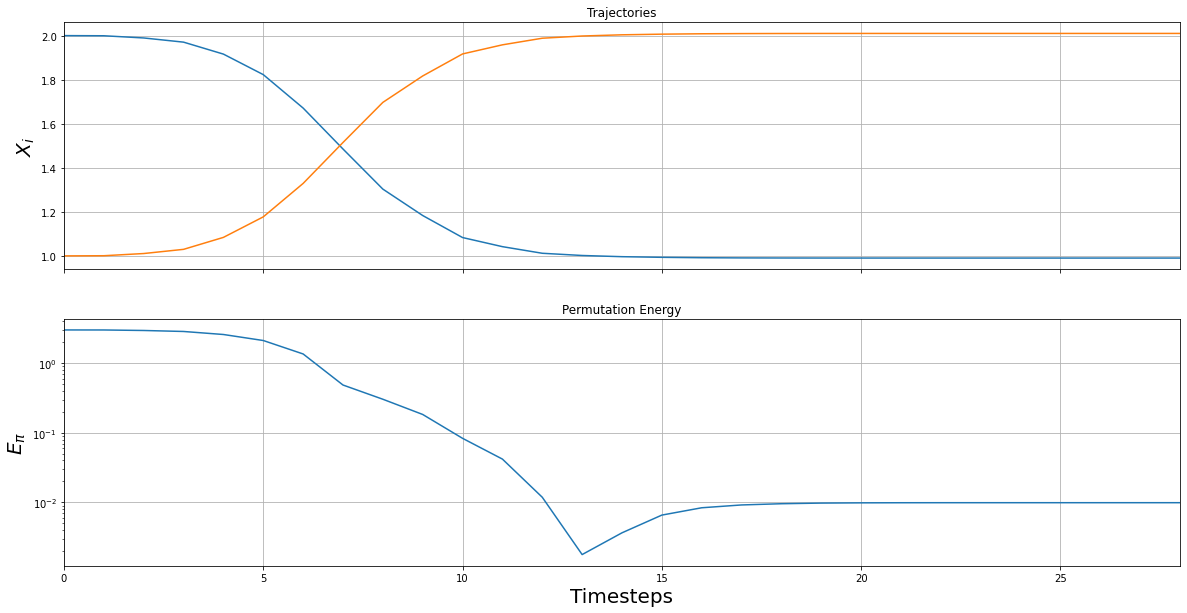

In [5]:
energies = [permutation_energy(traj, groundtruth) for traj in output.y[:len(nums)].T]
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

for ax, (title, lbl), data in zip(
    axes, 
    [("Trajectories", "$X_i$"), ("Permutation Energy", "$E_\pi$")], 
    [output.y[:len(nums)].T, energies]
):
    ax.plot(data)
    ax.set_title(title)
    ax.set_xlim(0, len(output.t)-1)
    ax.set_ylabel(lbl, fontsize=20)
    ax.grid()
    if title == "Permutation Energy":
        ax.semilogy()

axes[1].set_xlabel("Timesteps", fontsize=20);

### 2. Smooth bubble sort (n > 2)

In [16]:
# control parameter initial value
gamma = 0.05

n = 10
nums = np.random.uniform(0, 20, n)
controls = np.ones(n-1)*gamma
init_conds = np.concatenate([nums, controls])

sorter = SortingSystem(n)

output = solve_ivp(
    sorter, 
    t_span=(0, 1000), 
    y0=init_conds, 
    method='Radau', 
    jac=sorter.jac, 
    jac_sparsity=sorter.sparse_mask(init_conds), 
)

solution = output.y[:len(nums), -1]
groundtruth = np.sort(nums)

print(f"Original list: {nums}")
print(f"Sorted list: {solution}")
print(f"Groundtruth: {groundtruth}")

Original list: [ 9.42691197  3.2927861  17.57921946  8.36229739  2.71899712  8.66071463
 11.31731741 17.14610226  1.95391334  1.17993608]
Sorted list: [ 1.11962616  2.01122571  2.70160591  3.28106913  8.3653369   8.65045107
  9.43537167 11.32714108 17.1582265  17.58814164]
Groundtruth: [ 1.17993608  1.95391334  2.71899712  3.2927861   8.36229739  8.66071463
  9.42691197 11.31731741 17.14610226 17.57921946]


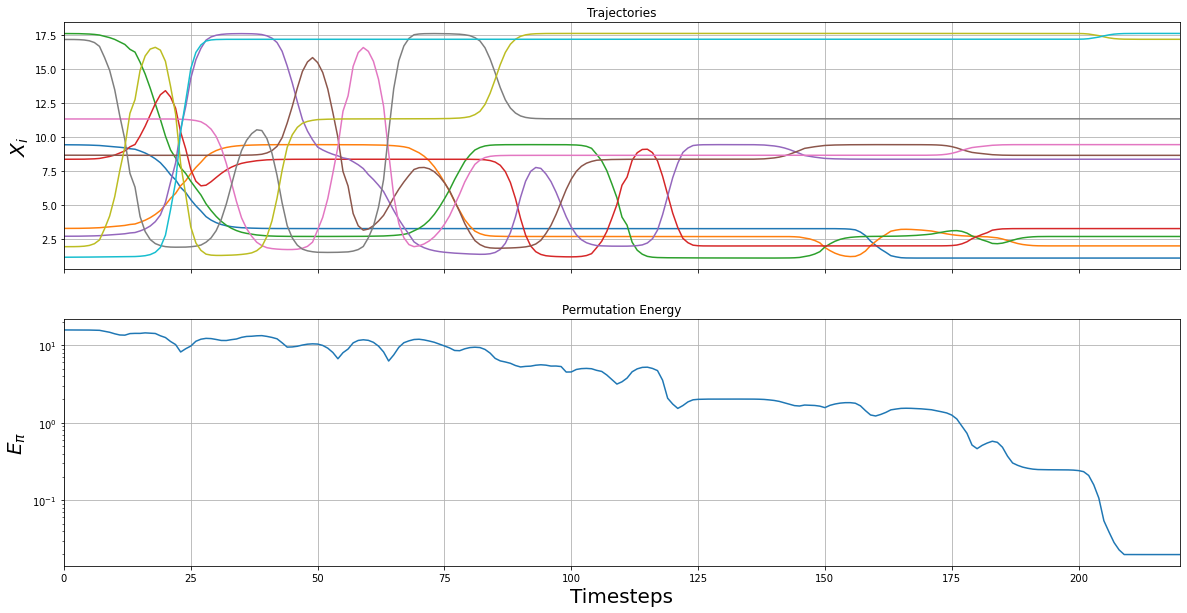

In [17]:
energies = [permutation_energy(traj, groundtruth) for traj in output.y[:n].T]
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

for ax, (title, lbl), data in zip(
    axes, 
    [("Trajectories", "$X_i$"), ("Permutation Energy", "$E_\pi$")], 
    [output.y[:n].T, energies]
):
    ax.plot(data)
    ax.set_title(title)
    ax.set_xlim(0, len(output.t)-1)
    ax.set_ylabel(lbl, fontsize=20)
    ax.grid()
    if title == "Permutation Energy":
        ax.semilogy()

axes[1].set_xlabel("Timesteps", fontsize=20);

## Learning a sorting system

Now we consider the case where we don't know the form of the ODE which sorts a given list. Let's learn it! As before, we know we need $n$ dynamical variables (representing each element in the list) and we'll assume we also know we need $n-1$ driving variables. The prior we'll employ for the RHS of the ODE system is that it is a polynomial function of the $n + n-1 = 2n-1$ dynamical and driving variables. In fact, this is a reasonable prior due to a recent result [Polynomial Time corresponds to Solutions of Polynomial Ordinary Differential Equations of Polynomial Length](https://arxiv.org/abs/1601.05360). 

TL;DR: Polynomially-sized systems of polynomial ODE's characterize polynomial-time computation! Moreover, such systems of ODEs are equivalent to Turing machines and are thus capable of universal computation.

For simplicity, lets just consider all the monomials of degree 1 and 2. This seems like cheating because we already know the original sorting ODE takes exactly this form, but we're just interested in seeing if it can be done.

In summary, we want to learn the coefficients of the ODE RHS such that, when integrated, sorts the initial conditions (the input list). The coefficients will be represented as a matrix, and the loss function will include an L1 regularization term in addition to the permutation energy to encourage sparsity in the learned coefficients.

In [172]:
def polynomial_system(q, _, params):
    n = (len(q)+1)//2
    x, y = q[:n], q[n:] 
    monomials = anp.concatenate([x, y, anp.outer(x, y).flatten()])
    return anp.dot(params, monomials)


def permutation_energy(nums, gt):
    sorted_nums = anp.sort(nums)
    min_disc = anp.diff(sorted_nums)
    disc = anp.diff(nums)
    return anp.abs(min_disc-disc).mean() + anp.abs(nums-gt).mean()


def ode_pred(params, func, timesteps, init_conds, tol=1e-4):
    n = (len(init_conds)+1)//2
    inshape = len(init_conds) + n*(n-1)
    param_mat = params.reshape(len(init_conds), inshape)

    final_sol = odeint(
        func, 
        init_conds, 
        timesteps, 
        tuple((param_mat,)),
        rtol=tol
    )[-1]

    return final_sol, n


def cost(params, times, init_conds, groundtruth, lamb=1e-4):
    final_sol, n = ode_pred(params, polynomial_system, times, init_conds)
    l1_loss = anp.mean(anp.abs(params))
    sorting_loss = permutation_energy(final_sol[:n], groundtruth)
    return sorting_loss + lamb*l1_loss


def callback(params, iter, _, timesteps, init_conds):
    sol, n = ode_pred(params, polynomial_system, timesteps, init_conds, tol=1e-4)
    print(f"Iter {iter} | Input: {init_conds[:n]} | Estimate: {sol[:n]}")
    

In [173]:
times = anp.linspace(0, 20, 200)
nums = np.random.rand(3)
groundtruth = np.sort(nums)

size = len(nums) + (len(nums)-1) + len(nums)*(len(nums)-1)
rand_state = npr.RandomState(0)
init_params = rand_state.randn(2*len(nums)-1, size)/100

init_conds = anp.concatenate([
    nums,
    anp.ones(len(nums)-1)*gamma
])

In [174]:
test_times = anp.linspace(0, 20, 300)

objective = lambda params, _: cost(params, times, anp.array(init_conds), groundtruth, lamb=1e-2)
callback_fn = lambda params, iter, g: callback(params, iter, g, test_times, init_conds)

# Specify gradient of objective function using autograd.
objective_with_grad = grad(objective)

optimized_params = adam(
    objective_with_grad, 
    init_params, 
    step_size=3e-3, 
    num_iters=100, 
    callback=callback_fn
)

Iter 0 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.52333928 0.52389344 0.9864424 ]
Iter 1 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.34586559 0.38885475 0.85808776]
Iter 2 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.18257752 0.26342726 0.74280173]
Iter 3 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.15208369 0.24701182 0.63513097]
Iter 4 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.16965284 0.27051987 0.53533532]
Iter 5 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.20898089 0.30394036 0.48279673]
Iter 6 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.25793087 0.34199609 0.45896606]
Iter 7 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.27720458 0.34866471 0.46184283]
Iter 8 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.27670634 0.33423162 0.4830033 ]
Iter 9 | Input: [0.24301478 0.33002673 0.62287488] | Estimate: [0.26272473 0.30505741 0.51738943]
Iter 10 | Input: [0.

We can see that we can *somewhat* learn to sort the input list. But the real test here is to see if we can sort *any* arbitrary list. A clear drawback here is that if we change the size of the input list, we have to learn a new coefficient matrix. Also, achieving good generalization will probably require even more input lists as training examples which raises many interesting questions:

+ Can we reuse the learned coefficients for learning to sort larger lists?
+ How many samples does it take to learn a good ODE sorting simulator?
+ And generally, how do we develop learning theory for optimization through integration?
+ Do the sample complexity bounds relate at all to those of the Neural-ODE?
+ What happens if we use a neural network or any universal function approximator as the ODE RHS?

To conclude, let's test the learned coefficients on a simple example:

In [186]:
test = np.array([1., 2., 3.])

# prepare initial conditions
init_conds = np.concatenate([
    test,
    np.ones(len(test)-1)*gamma
])

test_sol, n = ode_pred(optimized_params.flatten(), polynomial_system, test_times, init_conds)

print(f"Input: {test} | Estimate: {test_sol[:n]}")

Input: [1. 2. 3.] | Estimate: [0.93439186 1.93586988 2.76749368]
